In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
alg_names = {
    "vmcts": "VerMCTS (ours)",
    "whole": "Whole sampling",
    "reflexion": "Reflexion",
    "rollout": "MCTS rollout",
}
colors = sns.color_palette("Set1", n_colors=4, ) # desat=.5)
color_names = dict(zip(alg_names.keys(), colors))

In [3]:
api = wandb.Api()
runs = api.runs(path="seas/vmcts")

In [17]:
tree_df = pd.DataFrame()

tree_groups = ["vmcts-dafny5-1", "vmcts-dafny5-2"]

tree_keys = [
    "final/n_tokens",
    "final/width",
    "final/depth",
    "final/total_nodes",
    "final/max_value",
    "final/min_value",
    "tree/max_value",
    "tree/min_value",
    "tree/depth",
    "tree/max_child_count",
    "tree/widen_count",
    "tree/mean_value",
    "tree/width",
    "tree/node_depth",
    "final/pass_at_5000",
    "final/pass_at_1000",
    "final/pass_at_2000"
]

keys = tree_keys
for run in runs:
    if run.group in tree_groups:
        history = run.summary
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["alg"] = run.group.split("-")[0]
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["model_arg_temp"] = run.config["model_arg_temp"]
        run_dict["problem_name"] = run.config["problem_name"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]

        run_df = pd.DataFrame(run_dict, index=[0])
        tree_df = pd.concat([tree_df, run_df])

In [18]:
len(tree_df)

995

# Tokens vs width/depth (one line per problem)

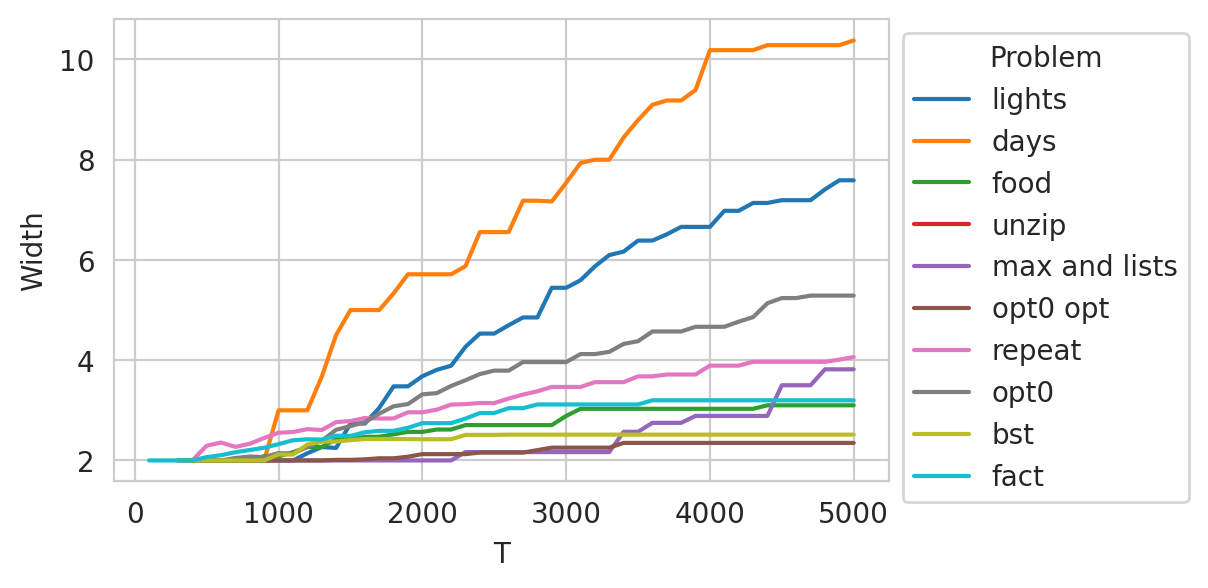

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
sns.set_style("whitegrid")

colors = sns.color_palette("Set1", n_colors=3)


# Group by problem and take mean of depth

#grouped = grouped.sort_values("final/pass_at_5000", ascending=False)
for problem in tree_df["problem_name"].unique():
    problem_df = tree_df[tree_df["problem_name"] == problem]
    ts = range(100, 5001, 100)
    ys = []
    for i, t in enumerate(ts):
        pass_df = problem_df[problem_df [f"final/n_tokens"] <= t]
        ys.append(pass_df["final/width"].mean())
    axs.plot(ts, ys, label=" ".join(problem.split("_")[1:]))

axs.set_ylabel("Width")
axs.set_xlabel("T")
axs.legend(loc="upper left", bbox_to_anchor=(1,1), title="Problem")

plt.show()

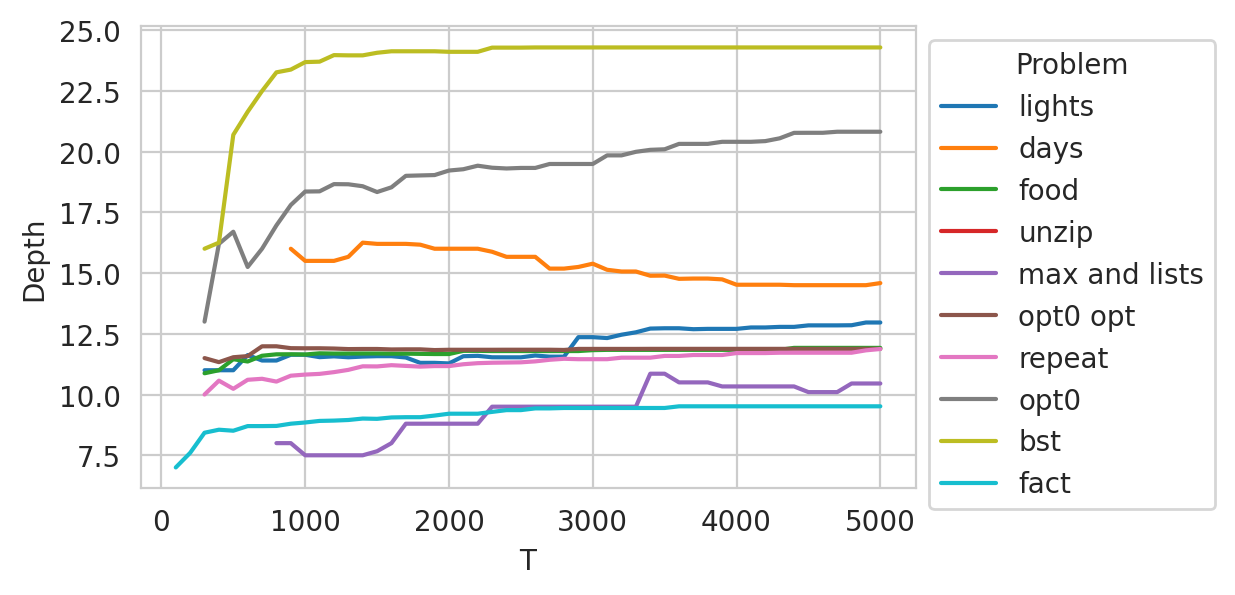

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
sns.set_style("whitegrid")

colors = sns.color_palette("Set1", n_colors=3)


# Group by problem and take mean of depth

#grouped = grouped.sort_values("final/pass_at_5000", ascending=False)
for problem in tree_df["problem_name"].unique():
    problem_df = tree_df[tree_df["problem_name"] == problem]
    ts = range(100, 5001, 100)
    ys = []
    for i, t in enumerate(ts):
        pass_df = problem_df[problem_df [f"final/n_tokens"] <= t]
        ys.append(pass_df["final/depth"].mean())
    axs.plot(ts, ys, label=" ".join(problem.split("_")[1:]))

axs.set_ylabel("Depth")
axs.set_xlabel("T")
axs.legend(loc="upper left", bbox_to_anchor=(1,1), title="Problem")

plt.show()

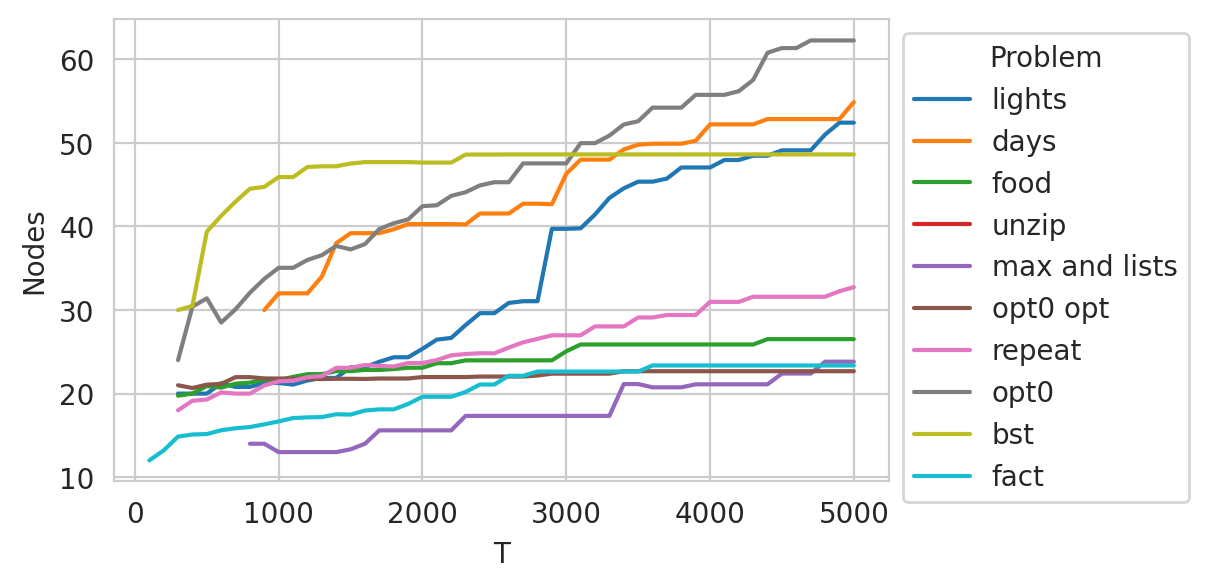

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
sns.set_style("whitegrid")

colors = sns.color_palette("Set1", n_colors=3)


# Group by problem and take mean of depth

#grouped = grouped.sort_values("final/pass_at_5000", ascending=False)
for problem in tree_df["problem_name"].unique():
    problem_df = tree_df[tree_df["problem_name"] == problem]
    ts = range(100, 5001, 100)
    ys = []
    for i, t in enumerate(ts):
        pass_df = problem_df[problem_df [f"final/n_tokens"] <= t]
        ys.append(pass_df["final/total_nodes"].mean())
    axs.plot(ts, ys, label=" ".join(problem.split("_")[1:]))

axs.set_ylabel("Nodes")
axs.set_xlabel("T")
axs.legend(loc="upper left", bbox_to_anchor=(1,1), title="Problem")

plt.show()